### DS 5110 Final Project
#### Michael Kolonay (mhk9c)
#### Tyler Entner (tje6gt)

#### File Description:
This file contains five (5) main sections:
1. Data Import and Preprocessing
      - Reads in twitter data, cleans variables, extracts features
2. Data Splitting / Sampling
      - Splits the dataset into training and testing datasets 
3. Exploratory Data Analysis and Visualizations
      - Constructs various metrics, graphs, and visuals to explore the training dataset
4. Model Construction
      - Constructs three families of models, with 6 models created in total
5. Model Evaluation
      - Extracts evaluation metrics from each model's performance on the testing (holdout) dataset:
              - AUROC, F1, Accuracy, Precision, etc.


#### Dataset Variable Descriptions:

| Variable Name      | Description |
| ----------- | ----------- |
|**external_author_id**|	An author account ID from Twitter|
|**author**	|The handle sending the tweet
|**content**	|The text of the tweet
|**region**|	A region classification, as determined by Social Studio
|**language**|	The language of the tweet
|**publish_date**|	The date and time the tweet was sent
|**harvested_date**|	The date and time the tweet was collected by Social Studio
|**following**|	The number of accounts the handle was following at the time of the tweet
|**followers**|	The number of followers the handle had at the time of the tweet
|**updates**|	The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
|**post_type**|	Indicates if the tweet was a retweet or a quote-tweet
|**account_type**|	Specific account theme, as coded by Linvill and Warren
|**retweet**|	A binary indicator of whether or not the tweet is a retweet
|**account_category**|	General account theme, as coded by Linvill and Warren
|**new_june_2018**|	A binary indicator of whether the handle was newly listed in June 2018
|**alt_external_id**|	Reconstruction of author account ID from Twitter, derived from article_url variable and the first list provided to Congress
|**tweet_id**|	Unique id assigned by twitter to each status update, derived from article_url
|**article_url**|	Link to original tweet. Now redirects to "Account Suspended" page
|**tco1_step1**|	First redirect for the first http(s)://t.co/ link in a tweet, if it exists
|**tco2_step1**|	First redirect for the second http(s)://t.co/ link in a tweet, if it exists
|**tco3_step1**|	First redirect for the third http(s)://t.co/ link in a tweet, if it exists

## SECTION 1: Data Import and Preprocessing
#### Data Ingestion

First, we'll load all of the datasets into dataframes. Each dataset will have the same schema, so we can load multiple datasets with one call.

In [1]:
# import context manager: SparkSession
from pyspark.sql import SparkSession

# import data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# import context manager: SparkSession
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,lit
from pyspark.sql import functions as F
from pyspark.mllib.stat import Statistics
from pyspark.sql import DataFrame


from pyspark.ml import Pipeline, PipelineModel, Transformer
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Normalizer


from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters

from pyspark import keyword_only

import time

import matplotlib.pyplot as plt

#Create session with custom app name, grab context
spark = SparkSession \
        .builder \
        .master("local") \
        .appName("team1_sp22_final_project") \
        .config("spark.executor.memory", '100g') \
        .config('spark.executor.cores', '8') \
        .config('spark.cores.max', '8') \
        .config("spark.driver.memory",'100g') \
        .getOrCreate()

sc = spark.sparkContext

In [2]:
# Set data directory
data_directory = "data/"

# Define custom schema of csv files
schema = StructType([StructField('external_author_id', StringType(), True), 
                     StructField('author', StringType(), True),
                     StructField('content', StringType(), True),
                     StructField('region', StringType(), True),
                     StructField('language', StringType(), True),
                     StructField('publish_date', StringType(), True),
                     StructField('harvested_date', StringType(), True),
                     StructField('following', IntegerType(), True),
                     StructField('followers', IntegerType(), True),
                     StructField('updates', IntegerType(), True),
                     StructField('post_type', StringType(), True),
                     StructField('account_type', StringType(), True),
                     StructField('retweet', IntegerType(), True),
                     StructField('account_category', StringType(), True),
                     StructField('new_june_2018', IntegerType(), True),
                     StructField('alt_external_id', StringType(), True),
                     StructField('tweet_id', StringType(), True),
                     StructField('article_url', StringType(), True),
                     StructField('tco1_step1', StringType(), True),
                     StructField('tco2_step1', StringType(), True),
                     StructField('tco3_step1', StringType(), True)                    
                    ])

# Create df by loading in all csv files in data_directory with schema
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep",",") \
    .schema(schema) \
    .load(data_directory)

In [3]:
# Filter for english content only
df_english = df.filter(df['language']=='English')
df_english.show(1)

+------------------+---------------+--------------------+-------------+--------+--------------+--------------+---------+---------+-------+---------+------------+-------+----------------+-------------+---------------+------------------+--------------------+--------------------+----------+----------+
|external_author_id|         author|             content|       region|language|  publish_date|harvested_date|following|followers|updates|post_type|account_type|retweet|account_category|new_june_2018|alt_external_id|          tweet_id|         article_url|          tco1_step1|tco2_step1|tco3_step1|
+------------------+---------------+--------------------+-------------+--------+--------------+--------------+---------+---------+-------+---------+------------+-------+----------------+-------------+---------------+------------------+--------------------+--------------------+----------+----------+
|        1647045721|CARRIETHORNTHON|New Study Reveals...|United States| English|6/1/2015 22:04|6/1/2

In [4]:
# Some information on the dataset:
print(df.count(), len(df.columns))
print(df_english.count(), len(df_english.columns))
df = df_english #replace df with english df

2946207 21
2096049 21


#### Data Cleaning
Now that the data has been ingested into a single dataframe, we can clean various columns and complete feature extraction.

Includes:
- Converts emojis to text strings
- Extracts domain information of any urls from the tweet
- Extracts handles from tweet content
- Counts emojis
- Extracts actual emojis
- Extracts urls
- Counts urls
- Extracts word count
- Extracts character count
- Extracts date info
- Assigns label based on LeftTroll, RightTroll = 1, all else = 0

In [5]:
# Create features
import emoji
import re
import datetime
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, ArrayType, IntegerType
import re
rx_b = re.compile(r"@[a-zA-Z0-9]+")
rx_url = re.compile(r"(?:http|ftp|https):\/\/(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])")


# *************************************************************
def convert_emojii(string): 
    '''
    convert emoji to string representation with demoji
    '''
    try:
        return demoji.replace_with_desc(string, ":")
    except:
        return "COULD NOT CONVERT EMOJII"
convert_emojii_UDF = func.udf(lambda z:convert_emojii(z),StringType())   
# test = convert_emojii("🐝🐝🐝")   
# print(test)

# *************************************************************
def extract_domain_information(url):  
    '''
    Extract domain information with tldextract
        Attempts to get registered domain if not parses out domain information from url
    '''
    try:        
        if(url):            
            ext = tldextract.extract(url)
            if(ext.registered_domain):                
                return ext.registered_domain
            else :                
                return f'{ext.subdomain}.{ext.domain}.{ext.suffix}'                
        else:            
            return "NA"        
    except Exception as e:        
        return "NA"    
extract_domain_information_UDF = func.udf(lambda z:extract_domain_information(z),StringType())   

# *************************************************************
def extract_handles(content): 
    '''
        gets all the handles in the tweet of the form @[a-zA-Z0-9]+ and returns an array
    '''
    try:
        if(content is not None):        
            result = re.findall(rx_b, content) 
            return result
        else:
            return []
    except:
        return []    
extract_handles_UDF = func.udf(lambda z:extract_handles(z),ArrayType(StringType(), True))   
# test = extract_handles("Hi @MichelleObama , remember when you praised Harvey Weinstein as 'a wonderful human being, a good friend and a powerhouse.")
# print(test)

# *************************************************************
def extract_hashes(content): 
    '''
        gets all the hashes in the tweet of the form #[a-zA-Z0-9]+ and returns an array
    '''
    try:
        if(content is not None):        
            result = re.findall(rx_hash, content) 
            return result
        else:
            return []
    except:
        return []    
extract_hashes_UDF = func.udf(lambda z:extract_hashes(z),ArrayType(StringType(), True))   
# test = extract_hashes("New Street Art by Case Maclaim in Karlstad Sweden   #streetart #art #arte https://t.co/tM2zwesUwd")
# print(test)

# *************************************************************
def count_emoji(string):
    '''
    Count number of emojis within a string
    '''
    if string:
        return emoji.emoji_count(string)
    else:
        return 0
count_emoji_udf = func.udf(lambda x: count_emoji(x), IntegerType())

# *************************************************************
def extract_emoji(string):
    '''
    Extract emojis by converting them to text
    '''
    if string:
        return emoji.demojize(emoji.distinct_emoji_lis(string))
    else:
        return 'None'
extract_emoji_udf = func.udf(lambda x: extract_emoji(x), StringType())

# *************************************************************
def extract_urls(string):
    '''
    Extract all urls in string
    '''
    if string:
#         urls = re.findall('(?:(?:https?|ftp):\\/\\/)?[\\w/\\-?=%.]+\\.[\\w/\\-&?=%.]+', string)
        urls = re.findall(rx_url, string)

        return urls
    else:
        return 'None'
extract_urls_udf = func.udf(lambda x: extract_urls(x), StringType())

# *************************************************************
def url_count(string):
    '''
    Count all urls in string
    '''
    if string:
        return(len(extract_urls(string)))
    else:
        return 0
url_count_udf = func.udf(lambda x: url_count(x), IntegerType())

# *************************************************************
def extract_url_parts(string):
    '''
    Return url in parts (https://stackoverflow.com/questions/27745/getting-parts-of-a-url-regex)
    '''
    if string:
        return re.findall('^((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?$', string)
    else:
        return 'None'

def extract_urls_redirect_base(string_1, string_2, string_3):
    '''
    Call extract_url_parts and create a list of hosts from twitters redirect columns
    '''
    try:
        host_list = ['', '', '']
        if string_3:
            url_parts = extract_url_parts(string_3)
            host_list[2] = url_parts[0][2]
        if string_2:
            url_parts = extract_url_parts(string_2)
            host_list[1] = url_parts[0][2]
        if string_1:
            url_parts = extract_url_parts(string_1)
            host_list[0] = url_parts[0][2]
        else:
            return 'None'
    except:
        return 'None'
    return host_list
extract_urls_redirect_base_udf = func.udf(lambda x,y,z: extract_urls_redirect_base(x,y,z), StringType())

# *************************************************************
def word_count(string):
    '''
    Count number of words in string (slightly error prone b/c split on spaces)
    '''
    if string:
        return len(string.split(' '))
    else:
        return 0
word_count_udf = func.udf(lambda x: word_count(x), IntegerType())

# *************************************************************
def character_count(string):
    '''
    Count number of characters in the tweet
    '''
    if string:
        return len(string)
    else: 
        return 0
character_count_udf = func.udf(lambda x: character_count(x), IntegerType())

# *************************************************************
def extract_date_info(string, info_type):
    '''
    IN WORK
    Extract date info
    '''
    date = datetime.datetime.strptime(string, '%m/%d/%Y %H:%M')
    
    if info_type == 'minute':
        info = date.minute
    elif info_type == 'hour':
        info = date.hour
    elif info_type == 'day':
        info = date.day
    elif info_type == 'month':
        info = date.month
    elif info_type == 'year':
        info = date.year    
    return info
extract_date_info_udf = func.udf(lambda x,y: extract_date_info(x,y), IntegerType())

# *************************************************************

def assignLabel(account_category):
    '''
        Assigns 1 - troll, or 0 - not-troll as a label to the tweet.
    '''
    if account_category in ("RightTroll", "LeftTroll" , "Fearmonger"):
        return 1
    else:
        return 0    
# test = assignLabel("Commercial")
# print(test)
assignLabel_udf = func.udf(assignLabel, IntegerType())

In [6]:
# Create dataframe witih all columns from feature extraction
df_enriched = df.withColumn("curated_content", convert_emojii_UDF(col("content"))) \
                .withColumn("tco1_step1_domain", extract_domain_information_UDF(col("tco1_step1"))) \
                .withColumn("tco2_step1_domain", extract_domain_information_UDF(col("tco2_step1"))) \
                .withColumn("tco3_step1_domain", extract_domain_information_UDF(col("tco3_step1"))) \
                .withColumn("handles", extract_handles_UDF(col("content"))) \
                .withColumn('hashes', extract_hashes_UDF(col('content'))) \
                .withColumn('emoji_count', count_emoji_udf(col('content'))) \
                .withColumn('emoji_text', extract_emoji_udf(col('content'))) \
                .withColumn('word_count', word_count_udf(col('content'))) \
                .withColumn('char_count', character_count_udf(col('content'))) \
                .withColumn('urls', extract_urls_udf(col('content'))) \
                .withColumn('url_count', url_count_udf(col('content'))) \
                .withColumn('url_hosts', extract_urls_redirect_base_udf(col('tco1_step1'), col('tco2_step1'), col('tco3_step1'))) \
                .withColumn("publish_date_timestamp",F.to_timestamp(F.col("publish_date"),"M/d/yyyy H:mm")) \
                .withColumn("publish_date_date",F.to_date(F.col("publish_date_timestamp"))) \
                .withColumn("publish_hour", F.hour(F.col("publish_date_timestamp"))) \
                .withColumn('label',assignLabel_udf(df['account_category']))

In [7]:
# Select columns and provide summary
df_enriched.select('publish_date','following','followers', 'emoji_count','word_count', 'char_count', 'url_count').summary().show()

+-------+--------------+-----------------+------------------+--------------------+------------------+------------------+------------------+
|summary|  publish_date|        following|         followers|         emoji_count|        word_count|        char_count|         url_count|
+-------+--------------+-----------------+------------------+--------------------+------------------+------------------+------------------+
|  count|       2096049|          2096049|           2096049|             2096049|           2096049|           2096049|           2096049|
|   mean|          null|4241.562128557109| 7146.343682328037|0.048428257163835385|13.181881721276554| 99.08216840350583| 0.863807096112734|
| stddev|          null| 6231.62797308032|11624.817215193514|  0.5200131955777119| 5.479144213764923|35.353085319885935|0.7578290022168858|
|    min|1/1/2013 16:16|                0|                 0|                   0|                 0|                 0|                 0|
|    25%|          n

In [8]:
# Set dataframe as new dataframe
df = df_enriched

## SECTION 2: Data Splitting / Sampling
Splits the dataset into 60/40 split, saves off for use later

In [9]:
# Split the dataset into training and testing, verify counts
training, testing = df.randomSplit([0.6, 0.4], seed=314)
training_len = training.count()
training_troll_len = training.filter(training['label']==1).count()
testing_len = testing.count()
testing_troll_len = testing.filter(testing['label']==1).count()

print("Training count: {} || Training Troll Count and Ratio: {}, {}".format(training_len, training_troll_len, training_troll_len/training_len))
print("Testing count : {} || Testing Troll Count and Ratio: {}, {}".format(testing_len, testing_troll_len, testing_troll_len/testing_len))

Training count: 1257166 || Training Troll Count and Ratio: 671830, 0.5344003894473761
Testing count : 838883 || Testing Troll Count and Ratio: 448399, 0.5345191164918112


In [10]:
# Write datasets to files for export and later use
save_data = False
if save_data:
    training.write.parquet('training.parquet')
    testing.write.parquet('testing.parquet')

In [11]:
# Read files back in, ensure no NAs
training = spark.read.parquet('tyler_training.parquet')
testing = spark.read.parquet('tyler_testing.parquet')
training = training.dropna(subset = 'content')
testing = testing.dropna(subset = 'content')

## SECTION 3: Exploratory Data Analysis and Visualizations
#### Group by various columns and explore frequency

In [12]:
# Unique counts of categorical columns:
from pyspark.sql.functions import desc
df.groupBy("region").count().sort(desc('count')).show()

+--------------------+-------+
|              region|  count|
+--------------------+-------+
|       United States|1825534|
|             Unknown| 239274|
|      United Kingdom|  16582|
|          Azerbaijan|   6847|
|             Germany|   1277|
|  Russian Federation|   1133|
|                null|   1132|
|               Italy|   1110|
|              Canada|    598|
|         Afghanistan|    455|
|             Belarus|    444|
|                Iraq|    423|
|              Israel|    402|
|United Arab Emirates|    362|
|             Ukraine|    145|
|               Spain|     69|
|              France|     67|
|               Egypt|     59|
|              Sweden|     41|
|              Mexico|     41|
+--------------------+-------+
only showing top 20 rows



In [13]:
# Frequency of posts types 
df.groupBy("post_type").count().sort(desc('count')).show()

+-----------+-------+
|  post_type|  count|
+-----------+-------+
|       null|1258752|
|    RETWEET| 801766|
|QUOTE_TWEET|  35531|
+-----------+-------+



In [14]:
# Frequency of account categories
df.groupBy("account_category").count().sort(desc('count')).show()

+----------------+------+
|account_category| count|
+----------------+------+
|      RightTroll|695149|
|        NewsFeed|596203|
|       LeftTroll|414097|
|    HashtagGamer|234094|
|      Commercial|112385|
|      NonEnglish| 26237|
|      Fearmonger| 10983|
|         Unknown|  6901|
+----------------+------+



#### Data Visualization
Create some sample graphics that detail features within the dataset


In [15]:
# Set flag to True if visualizations are desired
import matplotlib.pyplot as plt
visuals = True
if visuals:
    df = training

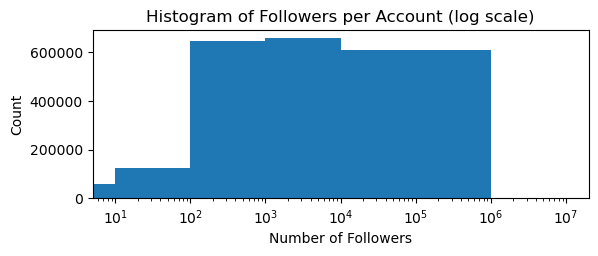

In [17]:
if visuals:

    # Visualize Follwers per account per post
    bins, counts = df.select('followers').rdd.flatMap(lambda x: x).histogram([0,10, 100, 1000, 10000, 1000000, 10000000])
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(bins[:-1], bins=bins, weights=counts)
    ax.set_xscale('log')
    plt.xlabel('Number of Followers')
    plt.ylabel('Count')
    plt.title('Histogram of Followers per Account (log scale)')
    plt.show()

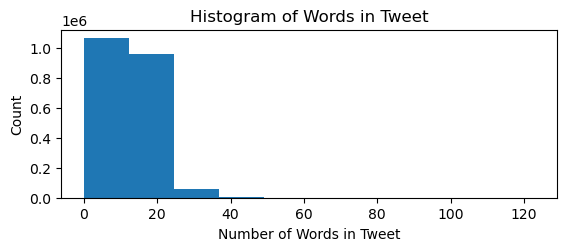

In [18]:
if visuals:
    # Visualize Word Count
    bins, counts = df.select('word_count').rdd.flatMap(lambda x:x).histogram(10)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(bins[:-1], bins=bins, weights=counts)
    plt.xlabel('Number of Words in Tweet')
    plt.ylabel('Count')
    plt.title('Histogram of Words in Tweet')
    plt.show()

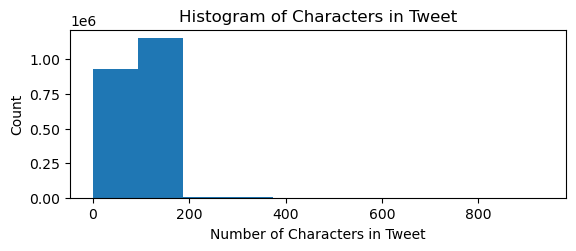

In [19]:
if visuals:
    # Visualize Character Count
    bins, counts = df.select('char_count').rdd.flatMap(lambda x:x).histogram(10)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(bins[:-1], bins=bins, weights=counts)
    plt.xlabel('Number of Characters in Tweet')
    plt.ylabel('Count')
    plt.title('Histogram of Characters in Tweet')
    plt.show()

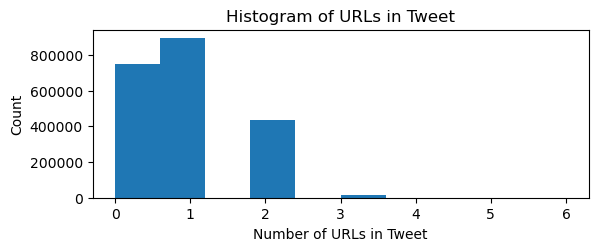

In [20]:
if visuals:
    # Visualize Number of URLs
    bins, counts = df.select('url_count').rdd.flatMap(lambda x:x).histogram(10)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(bins[:-1], bins=bins, weights=counts)
    plt.xlabel('Number of URLs in Tweet')
    plt.ylabel('Count')
    plt.title('Histogram of URLs in Tweet')
    plt.show()

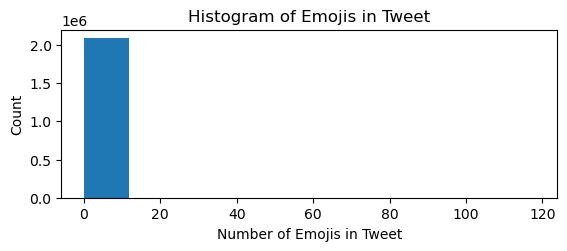

In [21]:
if visuals:
    # Visualize Number of Emojis
    bins, counts = df.select('emoji_count').rdd.flatMap(lambda x:x).histogram(10)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(bins[:-1], bins=bins, weights=counts)
    plt.xlabel('Number of Emojis in Tweet')
    plt.ylabel('Count')
    plt.title('Histogram of Emojis in Tweet')
    plt.show()

In [ ]:
# Code to install package wordcloud if needed:
#! pip install wordcloud

In [22]:
# Create helper function and import various statements for wordcloud visualizations
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, ArrayType, IntegerType

def clean_tokens(string_array):
    import re
    cleaned_words = ['']
    for word in string_array:
        #if word[0] == '#':
        #    clean = re.sub('[^\P{P}#]+', "", word)
        #else:
        if 'http' in word:
            continue
        else:
            clean = re.sub("[^A-Za-z]+", "", word)
        
        cleaned_words.append(clean)

    
    cleaned_words = [word for word in cleaned_words if word]
    return cleaned_words
clean_tokens_udf = func.udf(lambda x: clean_tokens(x), ArrayType(StringType(), True))


In [ ]:
#Verify cleaned words custom function works
#clean_token_words.select('cleaned_words').show(5, truncate = False)

In [23]:
# Transform content of the data for input into world cloud
from wordcloud import WordCloud
data_full = training.union(testing)

tok_content = Tokenizer(inputCol="content", outputCol="words")
token_words = tok_content.transform(data_full)
clean_token_words = token_words.withColumn("cleaned_words", clean_tokens_udf(col("words")))

remover_content = StopWordsRemover(inputCol="cleaned_words", outputCol="cleaned_words_filtered")
no_stop_words = remover_content.transform(clean_token_words)

In [24]:
# Filter data to split between troll and non troll for visualization purposes
troll_words = no_stop_words.filter(no_stop_words['label'] == 1)
not_troll_words = no_stop_words.filter(no_stop_words['label'] == 0)
right_troll = no_stop_words.filter(no_stop_words['account_category'] == 'RightTroll')
left_troll = no_stop_words.filter(no_stop_words['account_category'] == 'LeftTroll')

In [25]:
# Create custom functions to limit retyping of code, and to clean some content
# *************************************************************
def remove_words(list_strings):
    '''
   Remove certain words from array of strings
    '''
    return([x for x in list_strings if x not in ['amp', 'u', 'rr', 'rt']])
remove_words_udf = func.udf(lambda x: remove_words(x), ArrayType(StringType(), True))

# *************************************************************

def create_word_cloud(data):
    '''
    Pipeline to select cleaned words, map into right format for word cloud package, and visualize
    '''
    data = data.select('cleaned_words_filtered')
    data = data.withColumn('cleaned_words_removed', remove_words_udf(col('cleaned_words_filtered')))
    data = data.select('cleaned_words_removed')
    data = data.rdd.flatMap(lambda x: x).collect()
    data = ' '.join(sent for sent in [' '.join(word for word in tweet) for tweet in data])
    data_cloud = WordCloud(max_words = 200, background_color = 'white').generate(data)
    
    plt.figure()
    plt.imshow(data_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    

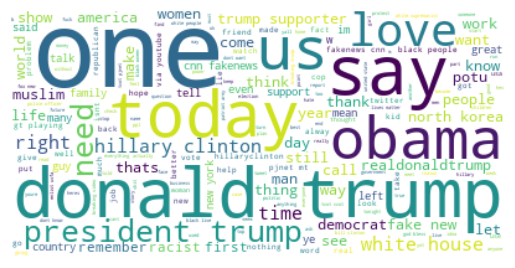

In [26]:
# Word cloud for trolls
create_word_cloud(troll_words)

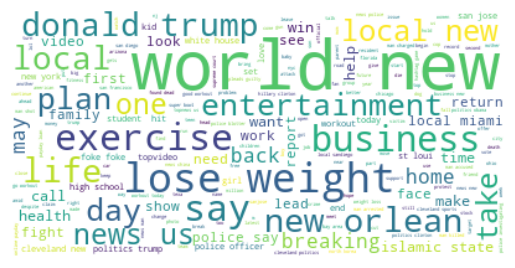

In [27]:
# Word cloud for non trolls
create_word_cloud(not_troll_words)

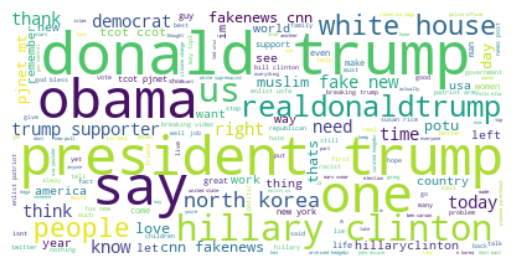

In [28]:
# Word cloud for right trolls
create_word_cloud(right_troll)

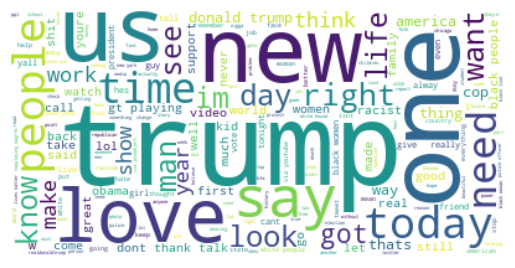

In [29]:
# Word cloud for left trolls
create_word_cloud(left_troll)

## SECTION 4 and SECTION 5: Model Construction and Model Evaluation
Custom functions were defined to evaluate models directly after training, see function 'binary_evaluation_metrics'

#### Model Building
Load in strong Spark Session, read in the training and testing datasets, and create some helper functions to increase code readability

In [ ]:
#Create session with custom app name, grab context
spark = SparkSession \
        .builder \
        .master("local") \
        .appName("team1_sp22_final_project") \
        .config("spark.executor.memory", '100g') \
        .config('spark.executor.cores', '8') \
        .config('spark.cores.max', '8') \
        .config("spark.driver.memory",'100g') \
        .getOrCreate()

sc = spark.sparkContext

In [ ]:
# Read in the data, ensure no NAs
training = spark.read.parquet('tyler_training.parquet')
testing = spark.read.parquet('tyler_testing.parquet')
training = training.dropna(subset = 'content')
testing = testing.dropna(subset = 'content')

In [60]:
def binary_evaluation_metrics(prediction):
    '''
    Custom function to create two evaluators and output metrics for a model
    '''
    evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'label', metricName = 'areaUnderROC')
    auROC = evaluator.evaluate(prediction)
    print("AUROC: {}".format(auROC))
    
    predictionsRdd = prediction.select("prediction","label").rdd
    predictionsRdd = predictionsRdd.map(lambda p: (float(p.label), (float(p.prediction))))
    metrics = MulticlassMetrics(predictionsRdd)
    print(f'Accuracy with MulticlassMetrics is {metrics.accuracy}')
    #print(f'Precision with MulticlassMetrics is {metrics.precision}')
    #print(f'Recall with MulticlassMetrics is {metrics.recall}')
    #print(f'F1 Score with MulticlassMetrics is {metrics.fMeasure}')

    print(metrics.confusionMatrix().toArray())
    
def cross_val_train_test(cv_model, training, testing):
    '''
    Custom function to time, train, and test various models
    '''
    t0 = time.time()
    cvModel = crossval.setParallelism(20).fit(training) # train 20 models in parallel
    print("train time:", time.time() - t0)
    print('-'*30)
    
    t0 = time.time()
    prediction = cvModel.transform(testing)
    print("test time:", time.time() - t0)
    print('-'*30)
    
    return cvModel, prediction

#### Model Subset 1: Logistic Regression

##### Simple Column Evaluation

In [31]:
#Simple columns = numerical columns
simple_cols = ['url_count', 'char_count', 'word_count', 'emoji_count', 'following', 'followers']

# Instantiate transformers
va = VectorAssembler(inputCols = simple_cols, outputCol = 'features')
normalizer = Normalizer(inputCol="features", outputCol= "features_norm", p=1.0)
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features_norm')

# Create parameter grid for model
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.maxIter, [5, 10]) \
    .build()

# Create pipeline
simple_cols_pipeline = Pipeline(stages = [va, normalizer, lr])

# Instantiate cross validation object
crossval = CrossValidator(estimator = simple_cols_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [32]:
# Utilize custom function to train and test
lr_simple_cvModel, lr_simple_prediction = cross_val_train_test(crossval, training, testing)

train time: 642.6213490962982
------------------------------
test time: 0.05814480781555176
------------------------------


In [61]:
# Extract / display performance metrics
binary_evaluation_metrics(lr_simple_prediction)

AUROC: 0.6942899373435232
Accuracy with MulticlassMetrics is 0.6997483558493854
[[240236. 101628.]
 [150248. 346771.]]


In [34]:
# Save model for ease of laoding in future
lr_simple_cvModel.save('lr_small_model_final')

##### Content Columns without URL, Text Only

In [35]:
class TokenCleaner(Transformer):
    """
    A custom Transformer that cleans tokens better than default spark due to various artifacts found in tweets
    """
    inputCol = Param(Params._dummy(), "inputCol", "input column name.", typeConverter=TypeConverters.toString)
    outputCol = Param(Params._dummy(), "outputCol", "output column name.", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol: str = "input", outputCol: str = "output"):
        super(TokenCleaner, self).__init__()
        self._setDefault(inputCol=None, outputCol=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, inputCol: str = "input", outputCol: str = "output"):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_col(self):
        return self.getOrDefault(self.inputCol)

    def get_output_col(self):
        return self.getOrDefault(self.outputCol)

    def _transform(self, df: DataFrame):
        inputCol = self.get_input_col()
        outputCol = self.get_output_col()

        transform_udf = func.udf(lambda x: clean_tokens(x), ArrayType(StringType(), True))

        return df.withColumn(outputCol, transform_udf(inputCol))


In [36]:
# Same process as initial model: initialize transformers, parameter grid, pipeline, and cross validation object

tok_content = Tokenizer(inputCol="content", outputCol="words")

cleaned_token = TokenCleaner(inputCol = 'words', outputCol = 'cleaned_words')

remover_content = StopWordsRemover(inputCol="cleaned_words", outputCol="words_filtered")
htf_content = HashingTF(inputCol="words_filtered", outputCol="content_htf")  

va = VectorAssembler(inputCols=["content_htf"], outputCol="features")
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')

paramGrid = ParamGridBuilder() \
    .addGrid(htf_content.numFeatures, [10, 100]) \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1]) \
    .build()

content_cols_pipeline = Pipeline(stages = [
                                          tok_content,
                                          cleaned_token,
                                          remover_content,
                                          htf_content,
                                          va,
                                          lr
                                         ])

crossval = CrossValidator(estimator = content_cols_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [37]:
# Train/test model
lr_words_cvModel, lr_words_prediction = cross_val_train_test(crossval, training, testing)

train time: 1041.8017973899841
------------------------------
test time: 0.10056877136230469
------------------------------


In [62]:
# Extract performance metrics
binary_evaluation_metrics(lr_words_prediction)

AUROC: 0.6230039320142252
Accuracy with MulticlassMetrics is 0.6317352956252541
[[193888. 112335.]
 [196596. 336064.]]


In [39]:
# Save model for ease of laoding in future
#lr_words_cvModel.save('lr_words_model_final')

##### Content Columns without URL, Add Simple Cols

In [40]:
# Same process as initial model: initialize transformers, parameter grid, pipeline, and cross validation object

va = VectorAssembler(inputCols=["content_htf", 'url_count', 'char_count', 'word_count', 'emoji_count', 'following', 'followers'], outputCol="features")
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')

#paramGrid = ParamGridBuilder() \
#    .addGrid(htf_content.numFeatures, [10, 50]) \
#    .addGrid(lr.maxIter, [10]) \
#    .addGrid(lr.regParam, [0.01]) \
#    .build()

paramGrid = ParamGridBuilder() \
    .addGrid(htf_content.numFeatures, [10, 50]) \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1]) \
    .build()


content_simple_cols_pipeline = Pipeline(stages = [
                                          tok_content,
                                          cleaned_token,
                                          remover_content,
                                          htf_content,
                                          va,
                                          lr
                                         ])

crossval = CrossValidator(estimator = content_simple_cols_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [41]:
# Train/test model
lr_complex_cvModel, lr_complex_prediction = cross_val_train_test(crossval, training, testing)

train time: 1071.3869063854218
------------------------------
test time: 0.10020327568054199
------------------------------


In [63]:
# Extract performance metrics
binary_evaluation_metrics(lr_complex_prediction)

AUROC: 0.7402681796760263
Accuracy with MulticlassMetrics is 0.7509581193086521
[[228600.  47033.]
 [161884. 401366.]]


In [ ]:
# Save model for ease of laoding in future
#lr_complex_cvModel.save('lr_complex_model_final')

#### Model Subset 2: Random Forest

##### Simple Columns

In [46]:
# Same process as initial model: initialize transformers, parameter grid, pipeline, and cross validation object

va = VectorAssembler(inputCols = simple_cols, outputCol = 'features')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .addGrid(rf.numTrees, [5, 10, 20]) \
    .build()

rf_simple_cols_pipeline = Pipeline(stages = [va, rf])

crossval = CrossValidator(estimator = rf_simple_cols_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [47]:
# Train/test model
rf_simple_cvModel, rf_simple_prediction = cross_val_train_test(crossval, training, testing)

train time: 1811.5996522903442
------------------------------
test time: 0.044901132583618164
------------------------------


In [64]:
# Extract performance metrics
binary_evaluation_metrics(rf_simple_prediction)

AUROC: 0.9018155100663681
Accuracy with MulticlassMetrics is 0.9040390614662593
[[339568.  29584.]
 [ 50916. 418815.]]


In [49]:
rf_simple_cvModel.save('rf_small_model_final')

##### Content and Simple

In [50]:
# Same process as initial model: initialize transformers, parameter grid, pipeline, and cross validation object

from pyspark.ml.classification import RandomForestClassifier

va = VectorAssembler(inputCols=["content_htf", 'url_count', 'char_count', 'word_count', 'emoji_count', 'following', 'followers'], outputCol="features")
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

paramGrid = ParamGridBuilder() \
    .addGrid(htf_content.numFeatures, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [10]) \
    .build()

content_cols_pipeline = Pipeline(stages = [
                                          tok_content,
                                          cleaned_token,
                                          remover_content,
                                          htf_content,
                                          va,
                                          rf
                                         ])

crossval = CrossValidator(estimator = content_cols_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)


In [51]:
# Train/test model
rf_complex_cvModel, rf_complex_prediction = cross_val_train_test(crossval, training, testing)

train time: 2827.5300137996674
------------------------------
test time: 0.1025545597076416
------------------------------


In [65]:
# Extract performance metrics
binary_evaluation_metrics(rf_complex_prediction)

AUROC: 0.892063901154498
Accuracy with MulticlassMetrics is 0.8946301212445598
[[333822.  31731.]
 [ 56662. 416668.]]


In [53]:
#rf_complex_cvModel.save('rf_complex_model_final')

#### Model Subset 3: Decision Trees

In [54]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer

In [55]:
# Same process as initial model: initialize transformers, parameter grid, pipeline, and cross validation object

#labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
va = VectorAssembler(inputCols=['url_count', 'char_count', 'word_count', 'emoji_count', 'following', 'followers'], outputCol="features")
#featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[va, dt])

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5]) \
    .build()

crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)


In [56]:
# Train/test model
#dt_cvModel, dt_predictions = cross_val_train_test(crossval, training, testing)

In [57]:
# Extract performance metrics
#binary_evaluation_metrics(predictions)

In [58]:
# Attempt simple method due to pipline errors:
va = VectorAssembler(inputCols=['url_count', 'char_count', 'word_count', 'emoji_count', 'following', 'followers'], outputCol="features")
va_model = va.transform(training)

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(va_model)

In [66]:
va_test = va.transform(testing)
preds = dt_model.transform(va_test)
binary_evaluation_metrics(preds)

AUROC: 0.8784182582385802
Accuracy with MulticlassMetrics is 0.8810728075309667
[[327994.  37276.]
 [ 62490. 411123.]]
